In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.cluster import KMeans
from sklearn.metrics import cohen_kappa_score, silhouette_score, confusion_matrix, adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score, calinski_harabasz_score, davies_bouldin_score
from scipy.optimize import linear_sum_assignment
from sklearn.decomposition import PCA
from itertools import cycle
import joblib

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from collections import Counter

In [ ]:
# Run this ONLY IF Yellowbrick shows "findfont" errors

import matplotlib.font_manager
plt.rcParams['font.family'] = 'DejaVu Sans'

In [ ]:
def combine_features(*arrays):
    return np.hstack(arrays)


In [ ]:
DPPpath = '/content/drive/My Drive/Colab/AS4/STEP2-feature_Engineering/'

def load_feature_set(path):

    # Load preprocessed features
    df_tfidf = pd.read_pickle(DPPpath + 'features_tfidf.pkl')
    df_bow = pd.read_pickle(DPPpath + 'features_bow.pkl')
    df_lda = pd.read_pickle(DPPpath + 'features_lda.pkl')
    df_2gr = pd.read_pickle(DPPpath + 'features_ngram2.pkl')
    df_wv = pd.read_pickle(DPPpath + 'features_word2vec.pkl')

    # Prepare data
    labels = df_tfidf['label']
    numeric_labels = df_tfidf['label_num'].values
    classes = np.unique(numeric_labels)
    from sklearn.preprocessing import label_binarize
    y_binarized = label_binarize(numeric_labels, classes=classes)

    # Feature matrices (drop label columns)
    X_tfidf = df_tfidf.drop(['label', 'label_num'], axis=1).values
    X_bow = df_bow.drop(['label', 'label_num'], axis=1).values
    X_lda = df_lda.drop(['label', 'label_num'], axis=1).values
    X_wv = df_wv.drop(['label', 'label_num'], axis=1).values
    X_2gr = df_2gr.drop(['label', 'label_num'], axis=1).values

    feature_sets = {
        'TF-IDF': X_tfidf,
        'BoW': X_bow,
        'LDA': X_lda,
        '2Grams': X_2gr,
        'Word2Vec': X_wv,
        'TF-IDF + LDA': combine_features(X_tfidf, X_lda),
        'BoW + LDA': combine_features(X_bow, X_lda)
    }

    return labels, numeric_labels, feature_sets

In [ ]:
from sklearn.manifold import TSNE
from scipy.sparse import issparse

def plot_clusters(X, labels, method_name):
    """Visualize clusters using t-SNE"""
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X.toarray() if issparse(X) else X)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis')
    plt.title(f'{method_name} Clustering (t-SNE visualization)')
    plt.colorbar(scatter)
    plt.show()

In [ ]:
def align_cluster_labels(true_labels, pred_labels):

    cm = confusion_matrix(true_labels, pred_labels)
    row_ind, col_ind = linear_sum_assignment(-cm)
    label_map = {pred: true for true, pred in zip(row_ind, col_ind)}
    aligned_labels = np.array([label_map[p] for p in pred_labels])
    return aligned_labels

In [ ]:
def model_KM(X, actual_y, reduced_dim = None):
    if reduced_dim:
        pca = PCA(n_components=reduced_dim, random_state=42)
        X = pca.fit_transform(X)

    X = X.toarray() if issparse(X) else X
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    cluster_labels = model.fit_predict(X)
    return model, cluster_labels

In [ ]:
def cohen_single(X, actual_y, k = 5, vect_path = "", raw_path = "", reduced_dim = None, plotting=True):
    if reduced_dim:
        pca = PCA(n_components=reduced_dim, random_state=42)
        X = pca.fit_transform(X)

    X = X.toarray() if issparse(X) else X
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    cluster_labels = model.fit_predict(X)
    print(f"Inertia: {model.inertia_:.3f}")

    aligned_labels = align_cluster_labels(actual_y, cluster_labels)
    # Record Cohen Kappa
    kappa = cohen_kappa_score(actual_y, aligned_labels)
    # print(f"Cohen's Kappa: {kappa:.3f}")
    results = {}
    results['kappa'] = cohen_kappa_score(actual_y, aligned_labels)
    results['silhouette'] = silhouette_score(X, aligned_labels)
    results['adjusted_rand_score'] = adjusted_rand_score(actual_y, aligned_labels)
    results['normalized_mutual_info_score'] = normalized_mutual_info_score(actual_y, aligned_labels)
    results['homogeneity_score'] = homogeneity_score(actual_y, aligned_labels)
    results['completeness_score'] = completeness_score(actual_y, aligned_labels)
    results['v_measure_score'] = v_measure_score(actual_y, aligned_labels)
    results['calinski_harabasz_score'] = calinski_harabasz_score(X, aligned_labels)
    results['davies_bouldin_score'] = davies_bouldin_score(X, aligned_labels)
    if plotting:
        visualizer = SilhouetteVisualizer(model)
        visualizer.fit(X)
        silhouette_scores = visualizer.silhouette_samples_
        cluster_labels = model.labels_

    if raw_path != "":
        top_words = []
        doc_raw = pd.read_pickle(raw_path)
        documents = doc_raw['text'].astype(str).tolist()

        for cluster in range(k):
            # Get indices of documents in this cluster
            cluster_indices = np.where(cluster_labels == cluster)[0]

            # Collect all words from documents in this cluster
            cluster_words = []
            for idx in cluster_indices:
                cluster_words.extend(documents[idx].split())

            # Get most frequent words in this cluster
            word_counts = Counter(cluster_words)
            top_words.append([word for word, count in word_counts.most_common(10)])

        coherence_model = CoherenceModel(
            topics=top_words,
            texts=[doc.split() for doc in documents],
            dictionary=Dictionary([doc.split() for doc in documents]),
            coherence='c_v'
        )
        results['coherence'] = coherence_model.get_coherence()
        # print(f"Coherence Score: {coherence_model.get_coherence():.3f}")
    if plotting:
        plot_clusters(X, aligned_labels, "K-Means")
    # Calculate average silhouette score for each cluster
    if plotting:
        avg_scores = []
        for cluster in range(k):
            mask = (aligned_labels == cluster)
            avg_score = silhouette_scores[mask].mean()
            avg_scores.append(avg_score)

        print(avg_scores)

    # Plot
    if plotting:
        df = pd.DataFrame({'Actual': actual_y, 'Cluster': aligned_labels})
        counts = df.groupby(['Actual', 'Cluster']).size().unstack()

        counts.plot(kind='bar', stacked=True, figsize=(8, 4))
        plt.title('Distribution of Actual Labels Across Clusters')
        plt.ylabel('Count')
        plt.xlabel('Actual Label')
        plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1))
        plt.tight_layout()
        plt.show()

    return results


Inertia: 251.924


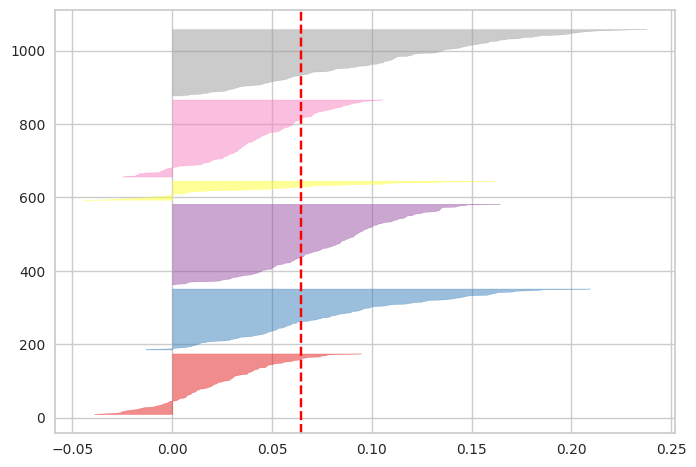

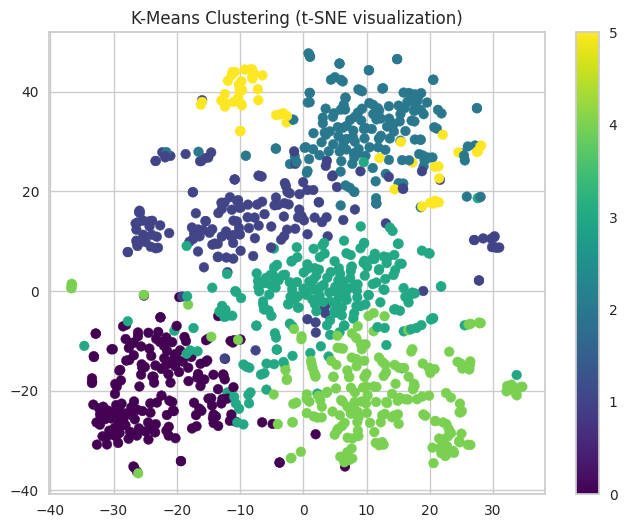

[0.10394326147315591, 0.022771963735553208, 0.07914805420387623, 0.07964086685298565, 0.04274298972902085, 0.03958475483079996]


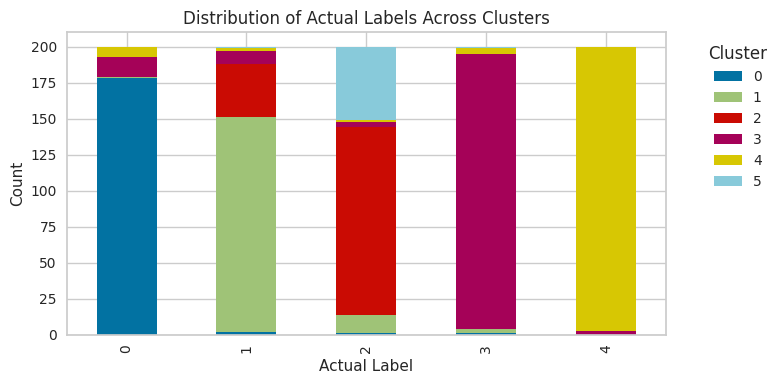

{'kappa': 0.8087836170737726,
 'silhouette': 0.06463293903362917,
 'adjusted_rand_score': 0.7301399992769106,
 'normalized_mutual_info_score': 0.7374218016057396,
 'homogeneity_score': 0.7638205767536437,
 'completeness_score': 0.712786828692323,
 'v_measure_score': 0.7374218016057397,
 'calinski_harabasz_score': 40.636300950210675,
 'davies_bouldin_score': 3.3891962185666706,
 'coherence': 0.474316965491335}

In [ ]:
import pandas as pd

DPPpath = '/content/drive/My Drive/Colab/AS4/STEP2-feature_Engineering/'
vecpath = DPPpath + 'vectorizer_tfidf.pkl'
excel_path = '/content/drive/My Drive/Colab/AS4/STEP1-data_prepare/final_labeled_dataset.xlsx'

# Load Excel raw data
doc_raw = pd.read_excel(excel_path)

# Extract the text column (adjust the column name if needed)
texts = doc_raw['Text'].astype(str).tolist()


In [ ]:
from itertools import product

def cohen_grid_search(X, actual_y,
                      k_values=[3, 5, 7],
                      reduced_dims=[None, 50, 100],
                      vect_path="", raw_path="",
                      plotting=False,
                      metric_name = 'adjusted_rand_score'):
    """
    Grid search wrapper for cohen_single. Evaluates combinations of k and reduced_dim.
    """
    best_score = -np.inf
    best_params = {}
    all_results = []

    for k, dim in product(k_values, reduced_dims):
        print(f"\nTesting k={k}, reduced_dim={dim}")
        results = cohen_single(X, actual_y, k=k, reduced_dim=dim,
                               vect_path=vect_path, raw_path=raw_path,
                               plotting=plotting)

        print(results)
        metric = results[metric_name]
        all_results.append({'k': k, 'reduced_dim': dim, **results})

        if metric > best_score:
            best_score = metric
            best_params = {'k': k, 'reduced_dim': dim, 'results': results}

    print("\nBest Parameters:")
    print(best_params)
    return best_params, all_results


In [ ]:
rawpath = DPPpath + 'raw_labeled.pkl'
vecpath = DPPpath + 'vectorizer_tfidf.pkl'
cohen_grid_search(
    X=feat['TF-IDF'],
    actual_y=numeric_labels,
    k_values=[4,5,6,7],
    reduced_dims=[None, 50, 100, 150, 200],
    vect_path=vecpath,
    raw_path=rawpath,
    plotting=False
)


Testing k=4, reduced_dim=None
Inertia: 908.700
{'kappa': 0.665, 'silhouette': 0.022884997435224798, 'adjusted_rand_score': 0.5640633911806412, 'normalized_mutual_info_score': 0.6480035384697984, 'homogeneity_score': 0.594322306304848, 'completeness_score': 0.7123449843128596, 'v_measure_score': 0.6480035384697984, 'calinski_harabasz_score': 15.310377498943424, 'davies_bouldin_score': 6.724427848050553, 'coherence': 0.4565970024312693}

Testing k=4, reduced_dim=50
Inertia: 170.954
{'kappa': 0.62, 'silhouette': 0.09751888602261456, 'adjusted_rand_score': 0.5284549696581186, 'normalized_mutual_info_score': 0.6367739349209425, 'homogeneity_score': 0.5734142098881803, 'completeness_score': 0.7158749380932948, 'v_measure_score': 0.6367739349209425, 'calinski_harabasz_score': 75.46054246649423, 'davies_bouldin_score': 2.9008846196062135, 'coherence': 0.44921242591714583}

Testing k=4, reduced_dim=100
Inertia: 261.778
{'kappa': 0.655, 'silhouette': 0.0681166591908034, 'adjusted_rand_score': 0

({'k': 6,
  'reduced_dim': 100,
  'results': {'kappa': 0.8087836170737726,
   'silhouette': 0.06463293903362917,
   'adjusted_rand_score': 0.7301399992769106,
   'normalized_mutual_info_score': 0.7374218016057396,
   'homogeneity_score': 0.7638205767536437,
   'completeness_score': 0.712786828692323,
   'v_measure_score': 0.7374218016057397,
   'calinski_harabasz_score': 40.636300950210675,
   'davies_bouldin_score': 3.3891962185666706,
   'coherence': 0.474316965491335}},
 [{'k': 4,
   'reduced_dim': None,
   'kappa': 0.665,
   'silhouette': 0.022884997435224798,
   'adjusted_rand_score': 0.5640633911806412,
   'normalized_mutual_info_score': 0.6480035384697984,
   'homogeneity_score': 0.594322306304848,
   'completeness_score': 0.7123449843128596,
   'v_measure_score': 0.6480035384697984,
   'calinski_harabasz_score': 15.310377498943424,
   'davies_bouldin_score': 6.724427848050553,
   'coherence': 0.4565970024312693},
  {'k': 4,
   'reduced_dim': 50,
   'kappa': 0.62,
   'silhouette

In [ ]:
all_trials

[{'k': 4,
  'reduced_dim': None,
  'kappa': 0.665,
  'silhouette': 0.022884997435224798,
  'coherence': 0.4565970024312693},
 {'k': 4,
  'reduced_dim': 50,
  'kappa': 0.62,
  'silhouette': 0.09751888602261456,
  'coherence': 0.44921242591714583},
 {'k': 4,
  'reduced_dim': 100,
  'kappa': 0.655,
  'silhouette': 0.0681166591908034,
  'coherence': 0.4530410871536643},
 {'k': 4,
  'reduced_dim': 150,
  'kappa': 0.66125,
  'silhouette': 0.05286939096480147,
  'coherence': 0.4564285313740366},
 {'k': 4,
  'reduced_dim': 200,
  'kappa': 0.4225000000000001,
  'silhouette': 0.03828818988882918,
  'coherence': 0.4540043117244192},
 {'k': 5,
  'reduced_dim': None,
  'kappa': 0.785,
  'silhouette': 0.02340325947263617,
  'coherence': 0.4593377480057744},
 {'k': 5,
  'reduced_dim': 50,
  'kappa': 0.5587500000000001,
  'silhouette': 0.08803645098275095,
  'coherence': 0.47797969418009545},
 {'k': 5,
  'reduced_dim': 100,
  'kappa': 0.6174999999999999,
  'silhouette': 0.06982408693697509,
  'coheren

In [ ]:
rawpath = DPPpath + 'raw_labeled.pkl'
vecpath = DPPpath + 'vectorizer_bow.pkl'
best_config, all_trials = cohen_grid_search(
    X=feat['BoW'],
    actual_y=numeric_labels,
    k_values=[4,5,6,7],
    reduced_dims=[None, 50, 100, 150, 200],
    vect_path=vecpath,
    raw_path=rawpath,
    plotting=False
)


Testing k=4, reduced_dim=None
Inertia: 236752.409
Cohen's Kappa: 0.607
Coherence Score: 0.459

Testing k=4, reduced_dim=50
Inertia: 84058.666
Cohen's Kappa: 0.613

Testing k=4, reduced_dim=100
Inertia: 112051.733
Cohen's Kappa: 0.610

Testing k=4, reduced_dim=150
Inertia: 132358.009
Cohen's Kappa: 0.607

Testing k=4, reduced_dim=200
Inertia: 149907.865
Cohen's Kappa: 0.575

Testing k=5, reduced_dim=None
Inertia: 234660.872
Cohen's Kappa: 0.503
Coherence Score: 0.460

Testing k=5, reduced_dim=50
Inertia: 82156.472
Cohen's Kappa: 0.536

Testing k=5, reduced_dim=100
Inertia: 110156.297
Cohen's Kappa: 0.550

Testing k=5, reduced_dim=150
Inertia: 129542.470
Cohen's Kappa: 0.766

Testing k=5, reduced_dim=200
Inertia: 145490.589
Cohen's Kappa: 0.766

Testing k=6, reduced_dim=None
Inertia: 231765.568
Cohen's Kappa: 0.672
Coherence Score: 0.463

Testing k=6, reduced_dim=50
Inertia: 80117.726
Cohen's Kappa: 0.451

Testing k=6, reduced_dim=100
Inertia: 107186.378
Cohen's Kappa: 0.729

Testing k=

In [ ]:
rawpath = DPPpath + 'raw_labeled.pkl'
vecpath = DPPpath + 'vectorizer_bow.pkl'
best_config, all_trials = cohen_grid_search(
    X=feat['BoW'],
    actual_y=numeric_labels,
    k_values=[4,5,6,7],
    reduced_dims=[None, 50, 100, 150, 200],
    vect_path=vecpath,
    raw_path=rawpath,
    plotting=False
)

In [ ]:
def eval_ideal_cluster_counts(X, actual_y, max_clusters = 7):
    wcss = []  # Within-Cluster-Sum-of-Squares
    cohen_kappa = []
    possible_k_values = range(2, max_clusters+1)

    figsih, axsih = plt.subplots(max_clusters-1, 1, figsize=(15,max_clusters * 3))
    for k in possible_k_values:
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
        kmeans.fit(X)
        cluster_labels = kmeans.fit_predict(X)

        aligned_labels = align_cluster_labels(actual_y, cluster_labels)
        # Record WCSS (inertia) score
        wcss.append(kmeans.inertia_)

        # Record Cohen Kappa
        kappa = cohen_kappa_score(actual_y, aligned_labels)
        cohen_kappa.append(kappa)
        print(f"Cohen's Kappa: {kappa:.3f}")

        # Create and fit SilhouetteVisualizer instance with KMeans instance
        axcur=axsih[k-2]
        visualizer = SilhouetteVisualizer(kmeans, ax=axcur)
        axcur.set_title(f"n_clusters = {k}")
        visualizer.fit(X)

        silhouette_scores = visualizer.silhouette_samples_
        cluster_labels = kmeans.labels_

        # Calculate average silhouette score for each cluster
        avg_scores = []
        for cluster in range(k):
            mask = (cluster_labels == cluster)
            avg_score = silhouette_scores[mask].mean()
            avg_scores.append(avg_score)

        # Plot vertical lines for each cluster's average score
        for cluster, avg_score in enumerate(avg_scores):
            axcur.axvline(
                x=avg_score,
                linestyle="--",
                linewidth=0.8,
                alpha=0.8,
                label=f"Avg for Cluster {cluster}" if cluster == 0 else ""
            )

    # Plot the elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(possible_k_values, wcss, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.title('Elbow Method for Optimal k')
    plt.show()


In [ ]:
labels, numeric_labels, feat = load_feature_set(DPPpath)

Cohen's Kappa: 0.236
Cohen's Kappa: 0.485
Cohen's Kappa: 0.681
Cohen's Kappa: 0.586
Cohen's Kappa: 0.763
Cohen's Kappa: 0.747
Cohen's Kappa: 0.643


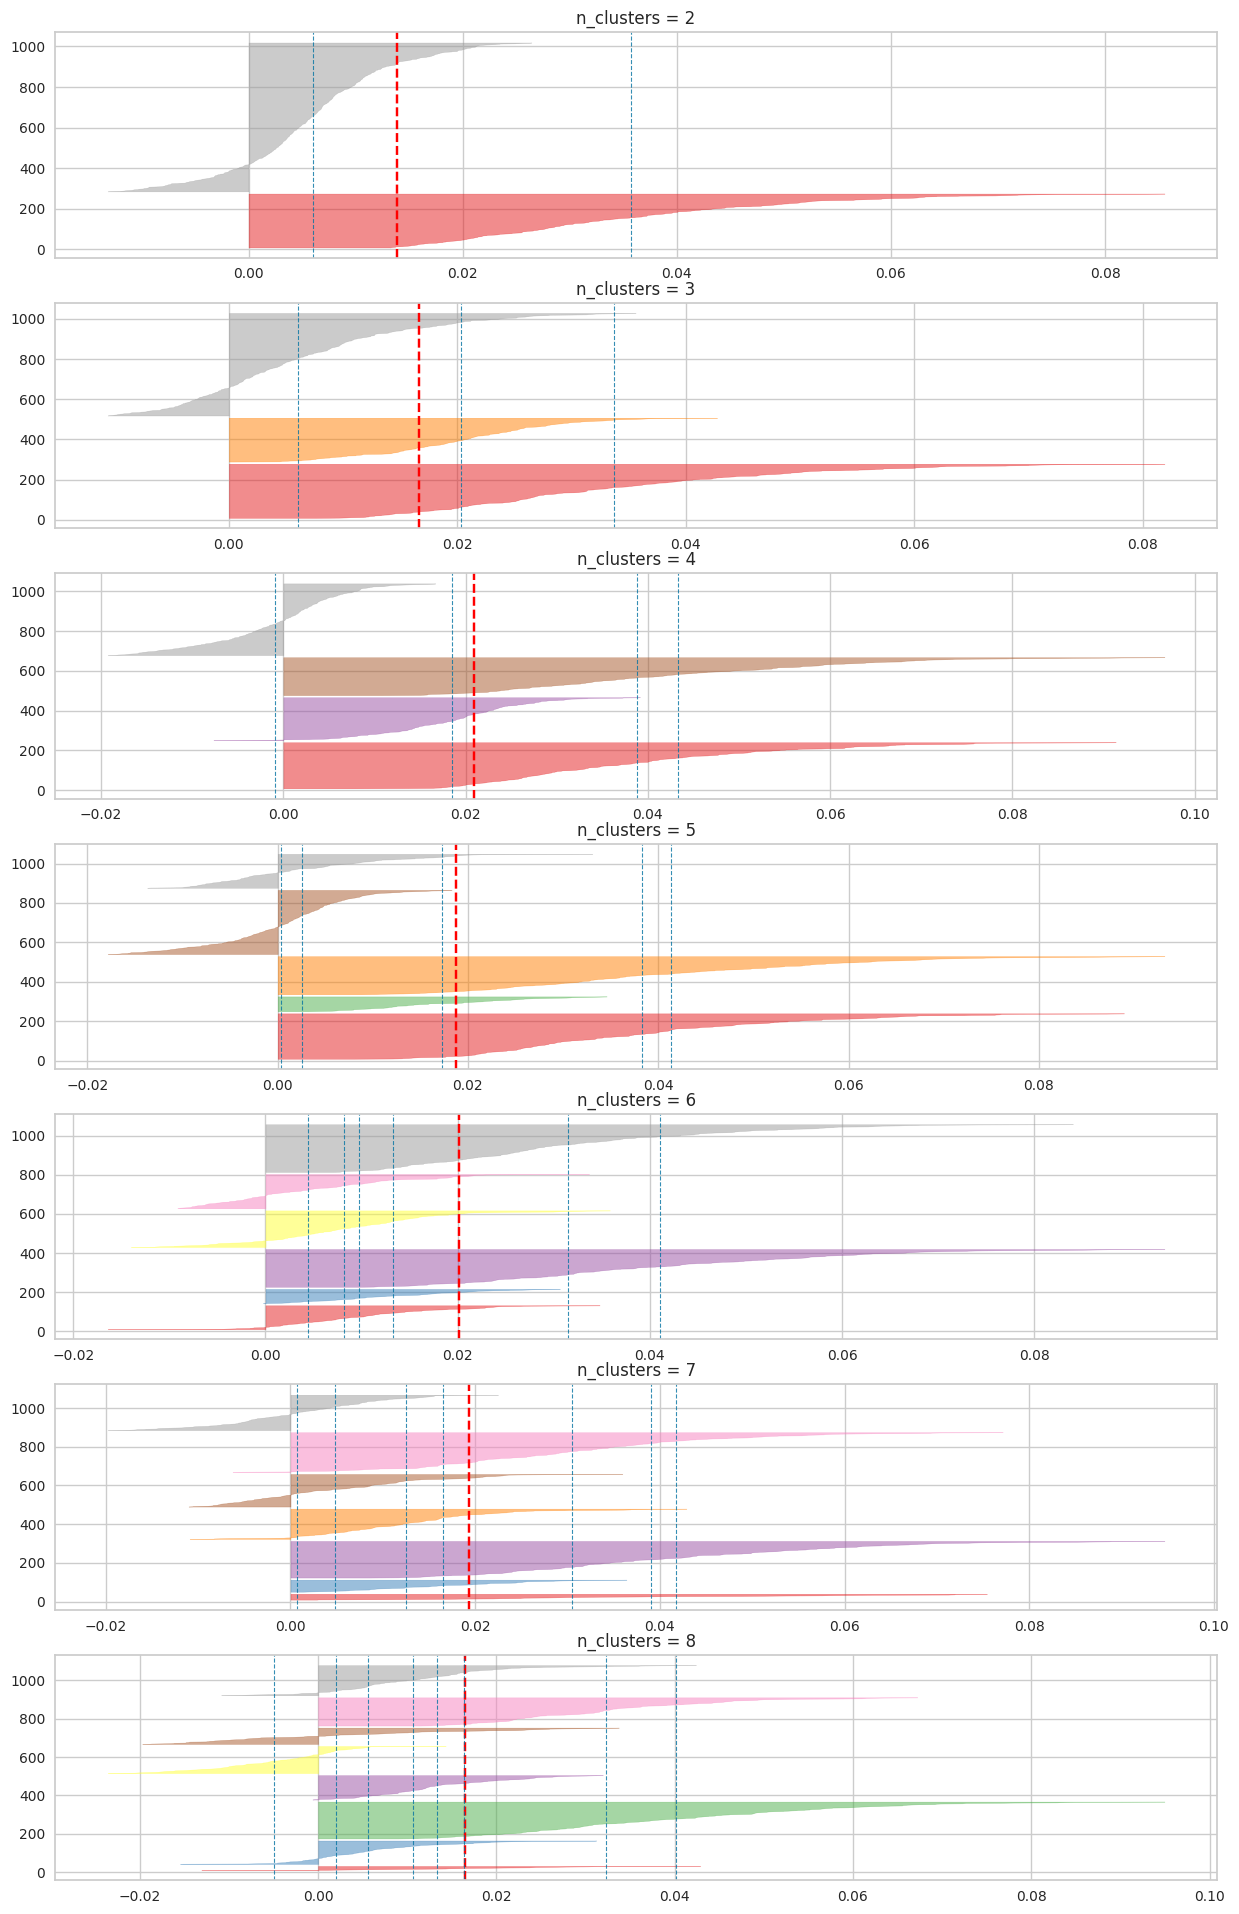

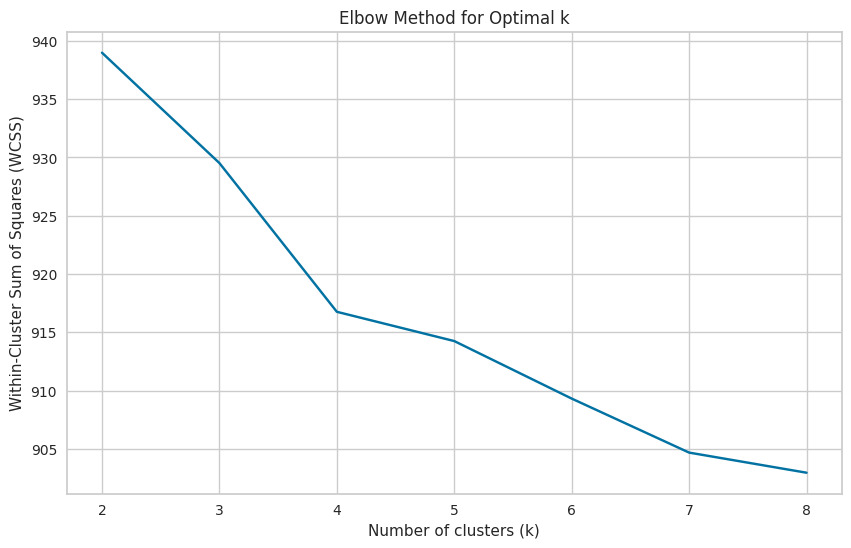

In [ ]:
eval_ideal_cluster_counts(feat['TF-IDF'], numeric_labels, max_clusters = 8)

Cohen's Kappa: 0.235
Cohen's Kappa: 0.460
Cohen's Kappa: 0.607
Cohen's Kappa: 0.503
Cohen's Kappa: 0.673
Cohen's Kappa: 0.626
Cohen's Kappa: 0.572


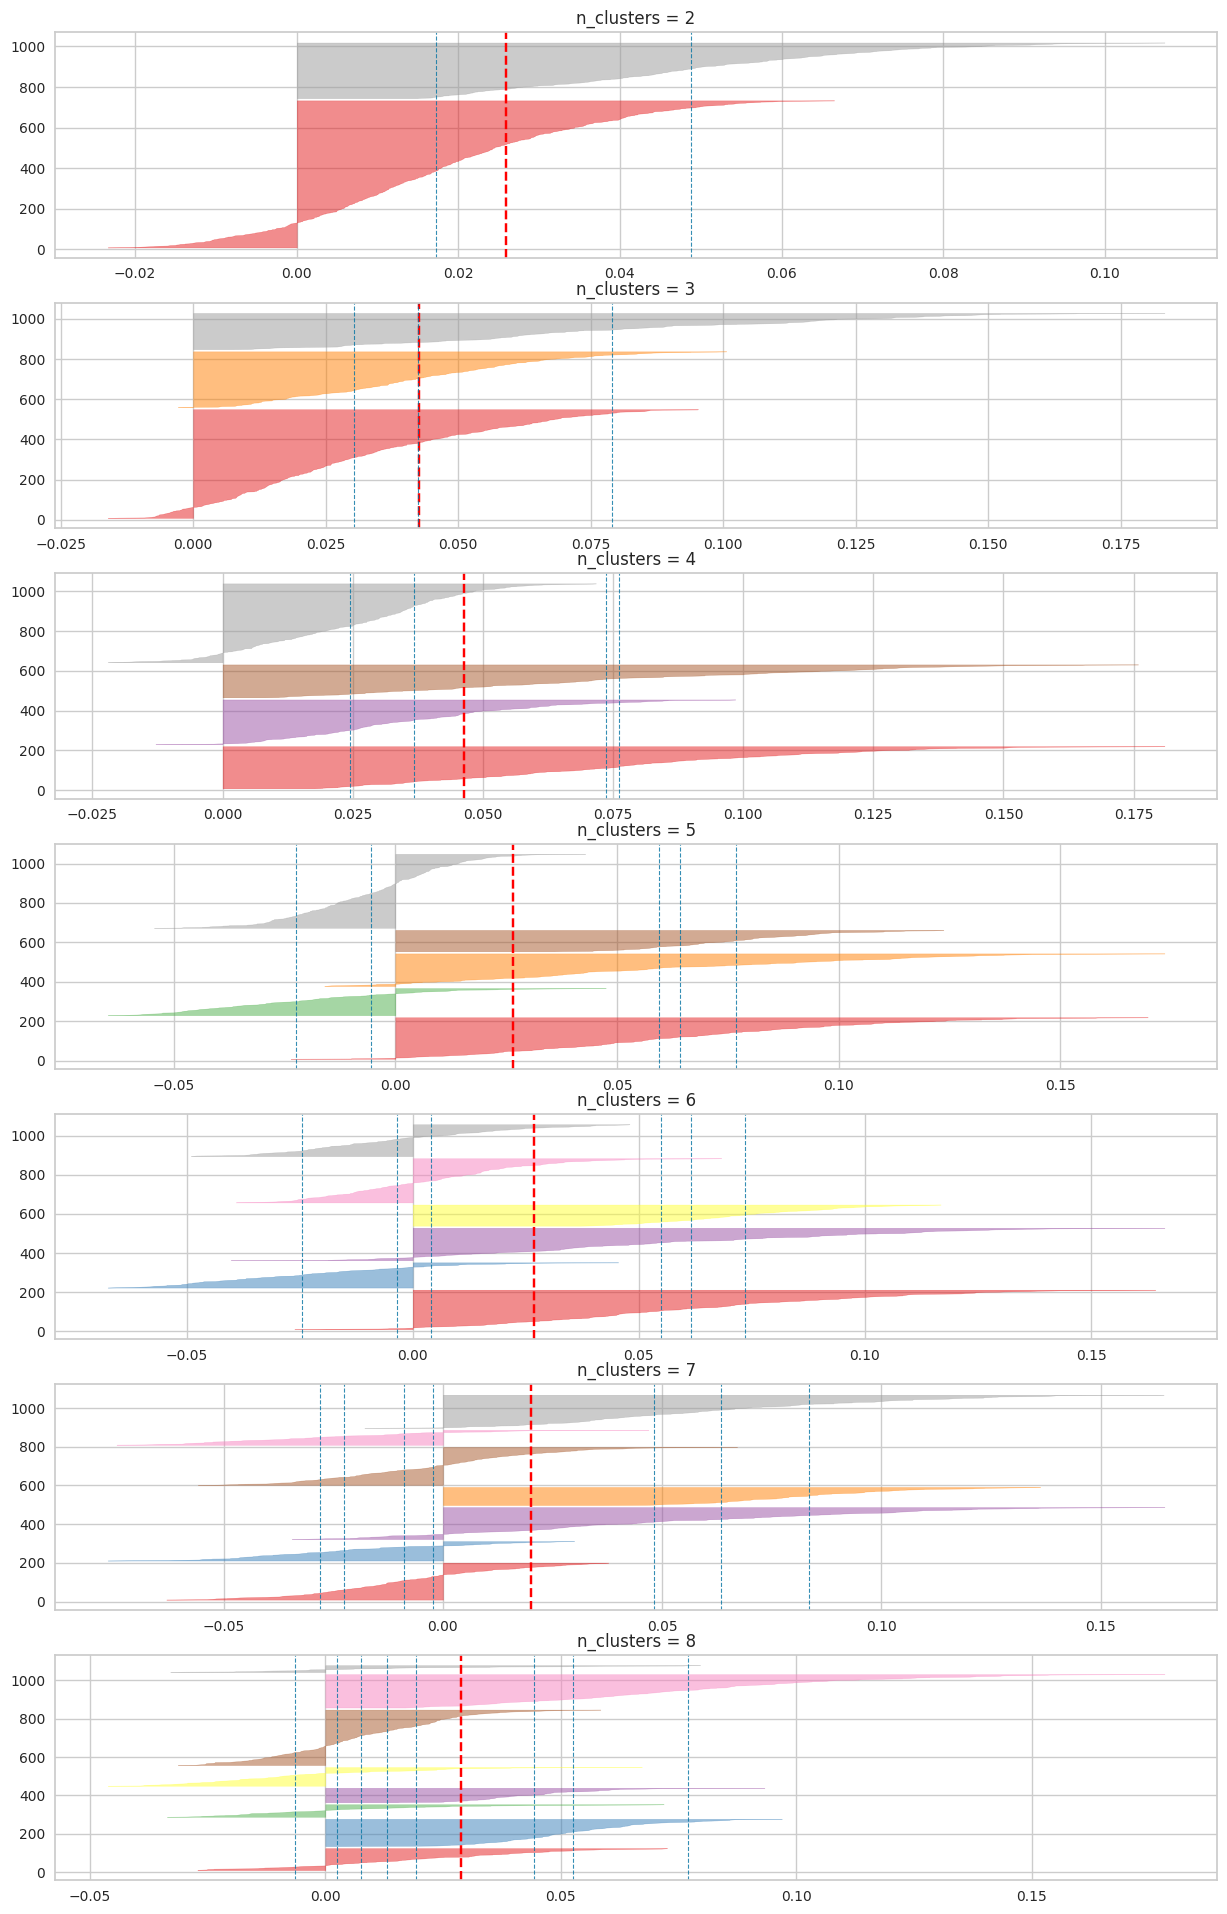

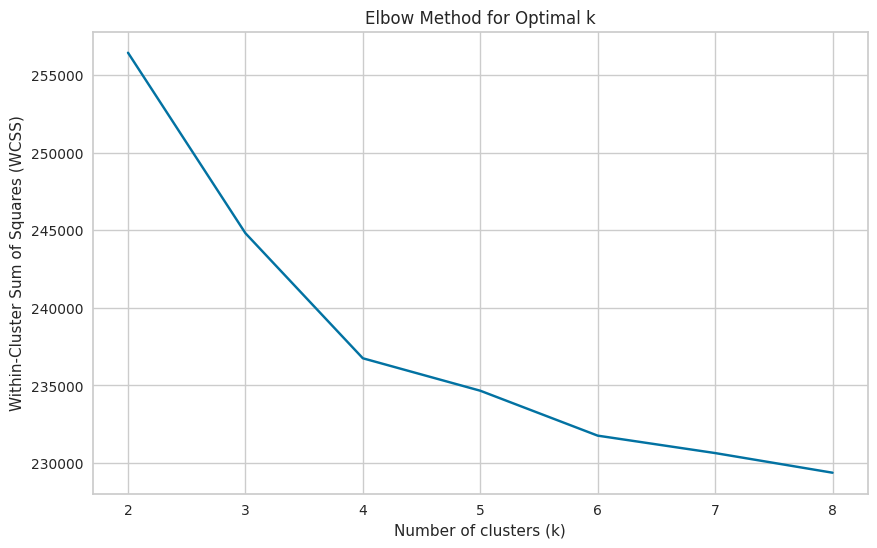

In [ ]:
eval_ideal_cluster_counts(feat['BoW'], numeric_labels, max_clusters = 8)

Cohen's Kappa: 0.194
Cohen's Kappa: 0.380
Cohen's Kappa: 0.461
Cohen's Kappa: 0.466
Cohen's Kappa: 0.418
Cohen's Kappa: 0.392
Cohen's Kappa: 0.413


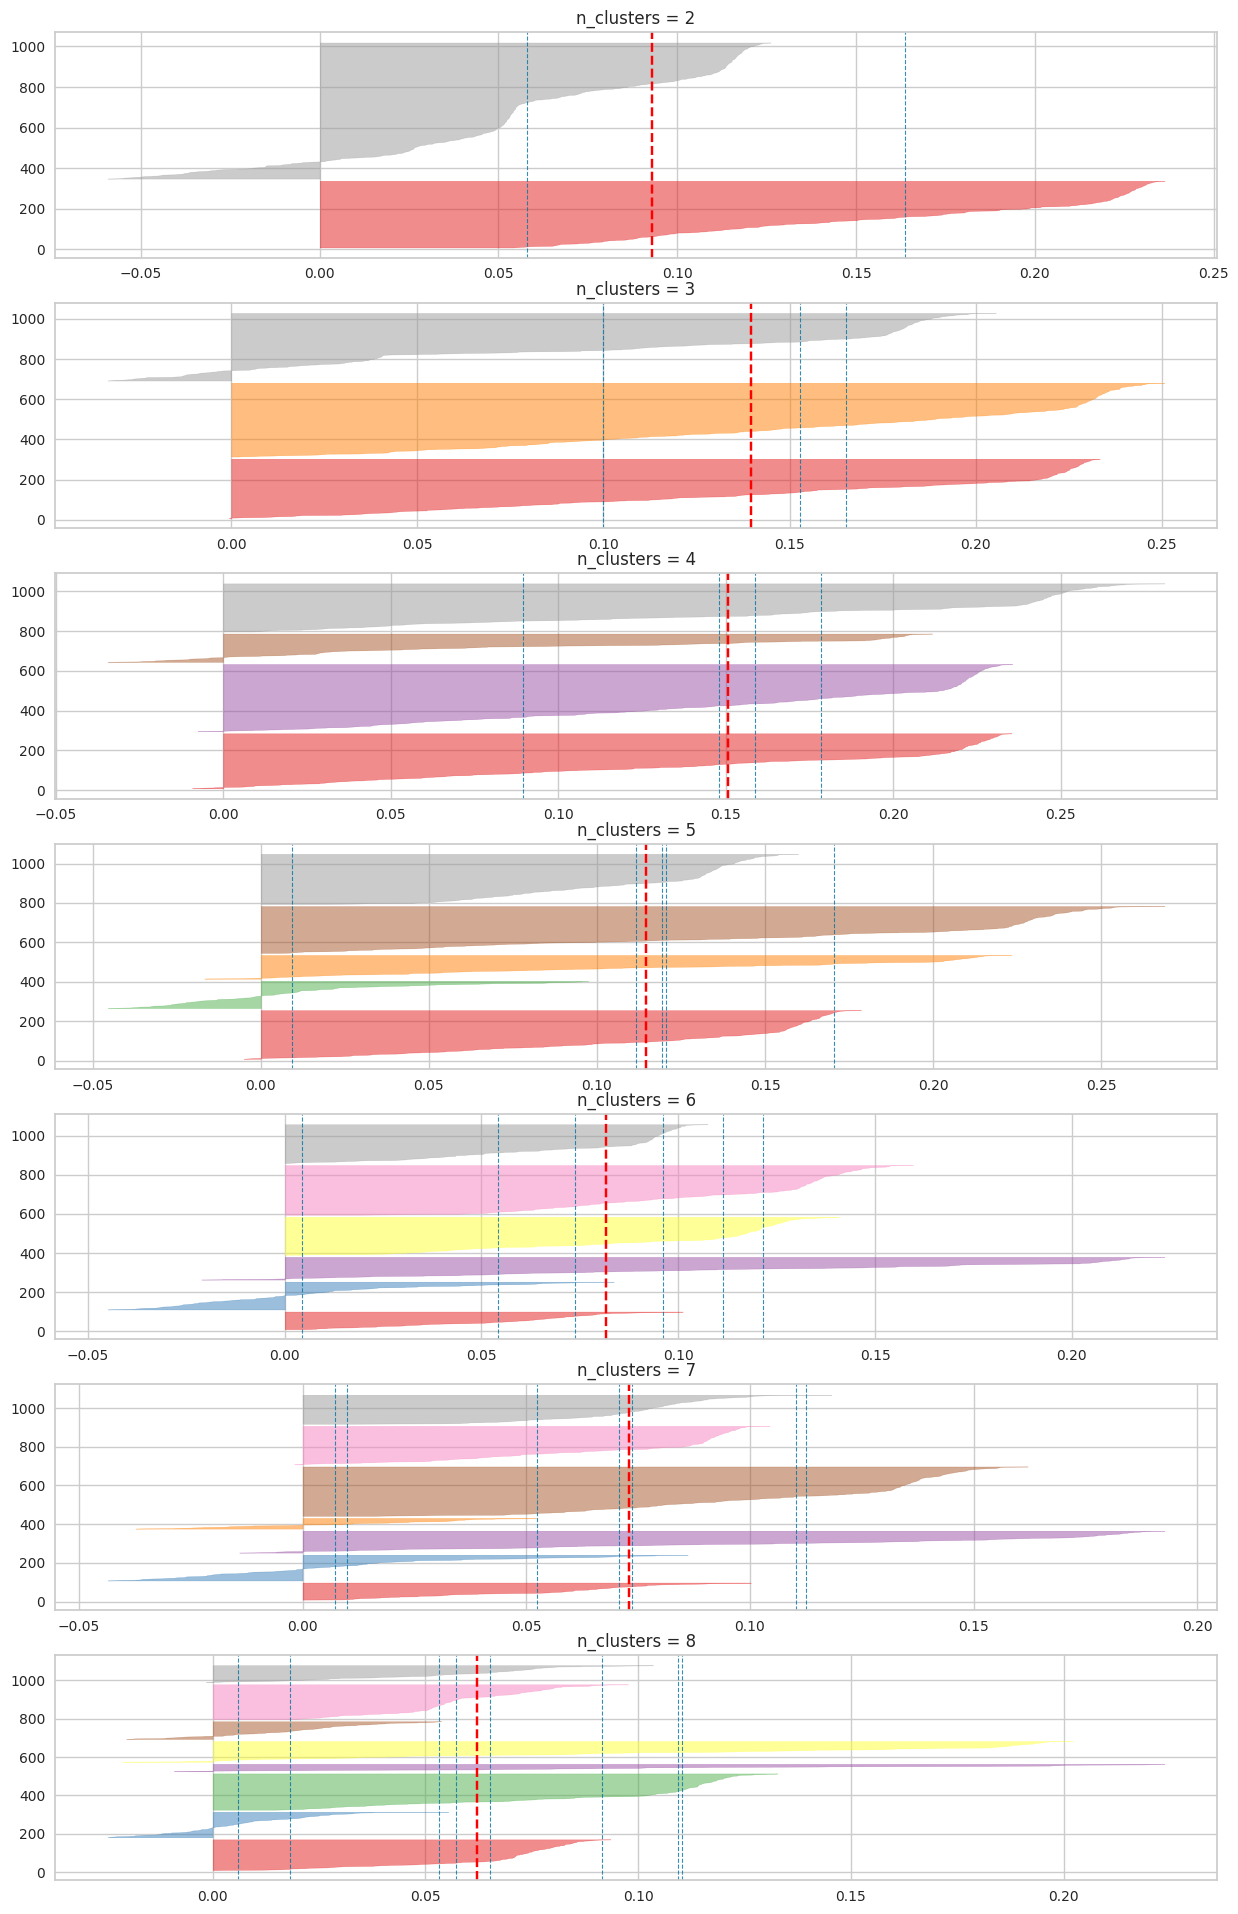

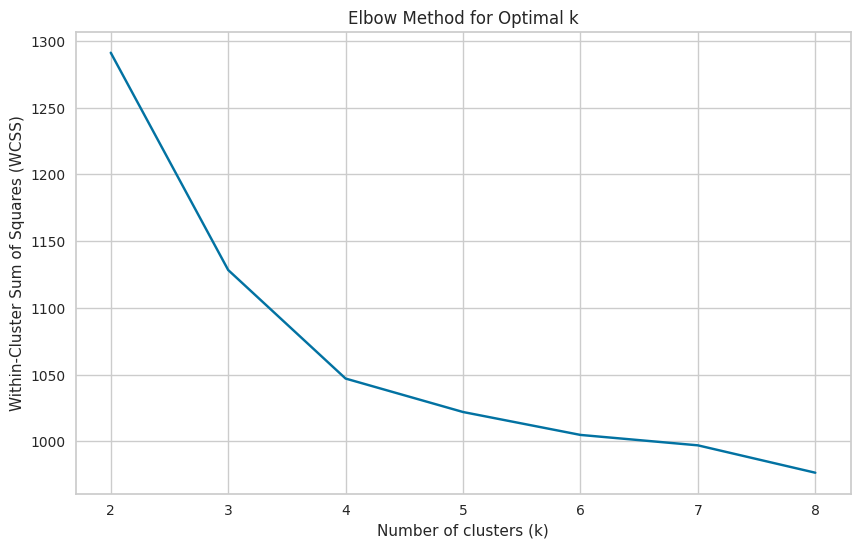

In [ ]:
eval_ideal_cluster_counts(feat['TF-IDF + LDA'], numeric_labels,  max_clusters = 8)

Cohen's Kappa: 0.081
Cohen's Kappa: 0.098
Cohen's Kappa: 0.109
Cohen's Kappa: 0.145
Cohen's Kappa: 0.147
Cohen's Kappa: 0.121
Cohen's Kappa: 0.109


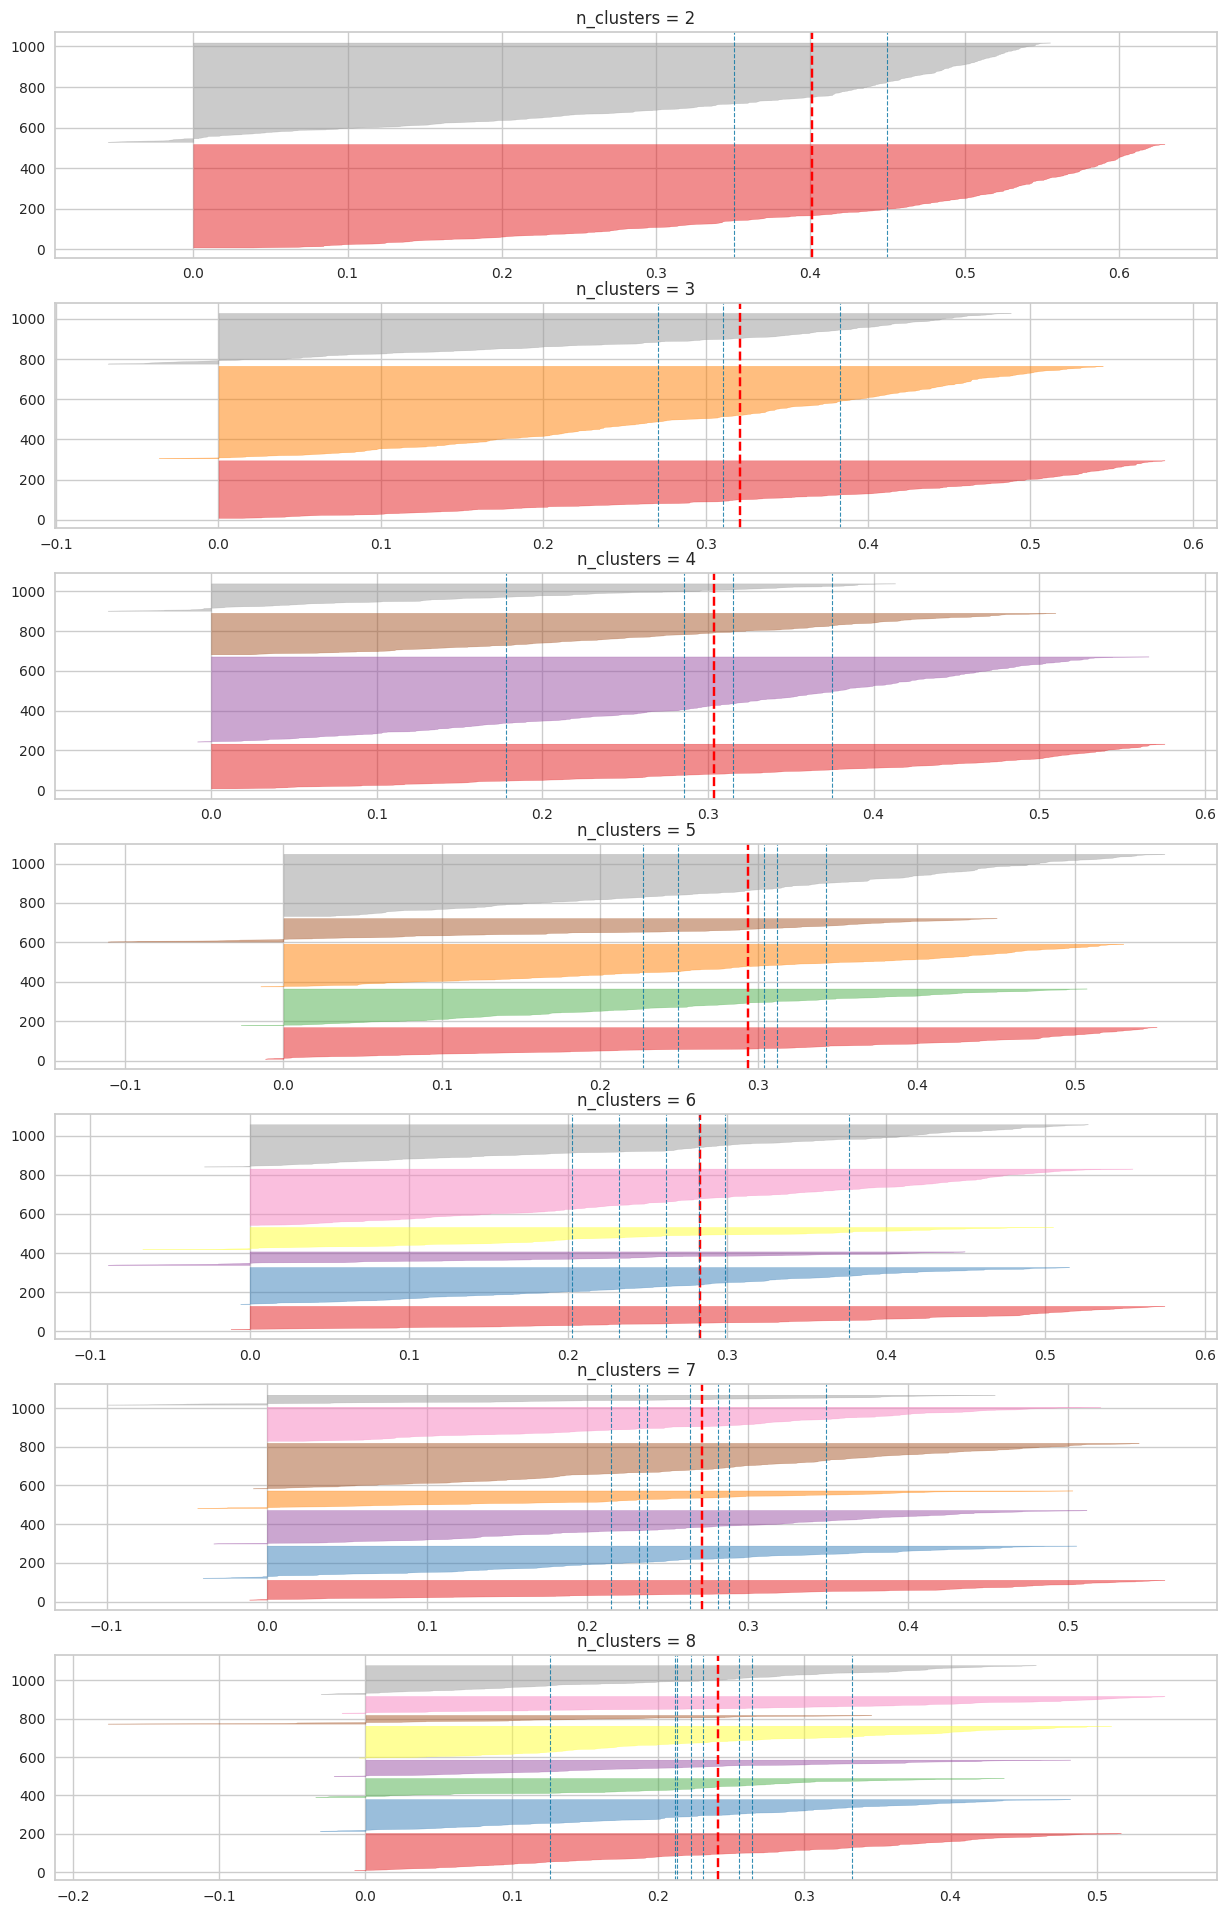

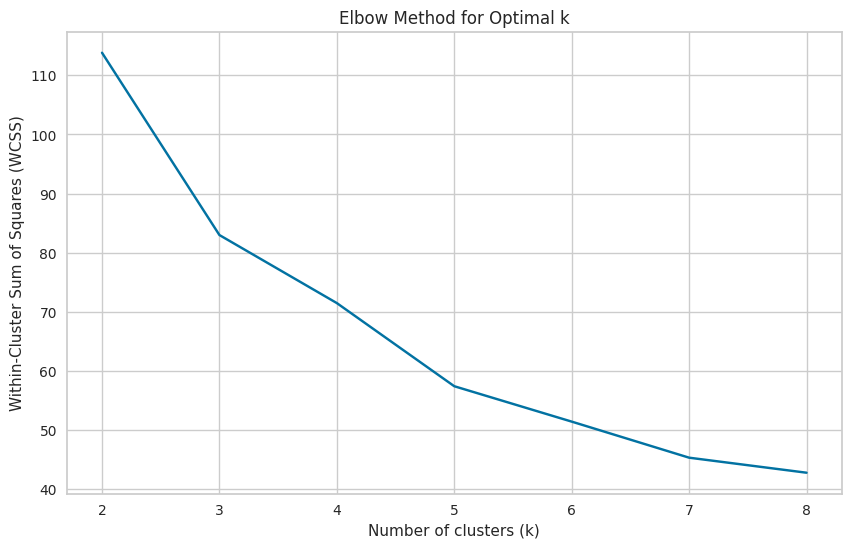

In [ ]:
eval_ideal_cluster_counts(feat['Word2Vec'], numeric_labels,  max_clusters = 8)